토큰화 - Konlpy.Okt

벡터화 - TF-IDF

세 개의 카테고리로 나누어 수행해봐도 성능 문제는 그대로임을 확인했습니다.  
결국 클래스 불균형을 해소하는 것과 데이터 양을 늘리는 작업이 필요할 것 같습니다.

### 라이브러리 및 데이터 불러오기

In [25]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

import numpy as np
import pandas as pd
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv("./1_final_data.csv", encoding='utf-8')
print(df.shape)
df.head(2)

(694, 9)


,id,title,score_val,category,descript,reviews,keyword1,keyword2,keyword3
0,35849217,쭈꾸미블루스 신촌본점,4.59,주꾸미요리,신촌 맛집 날치알쌈과 매운 쭈꾸미,노포식당요즘 인기있는곳이래서 왔어요 주꾸미 삼겹 꽃게새우사리추가해서.먹었는데요 양념...,음식이 맛있어요,친절해요,인테리어가 멋져요
1,1749849331,금고기비스트로 신촌,NaN,"육류,고기요리",NaN,지나가는데 너무 예뻐서 술집인 줄 알았는데 알고 보니까 신촌 삼겹살 맛집이더라구요 ...,음식이 맛있어요,고기 질이 좋아요,친절해요


### 전처리

<Axes: xlabel='new_category'>

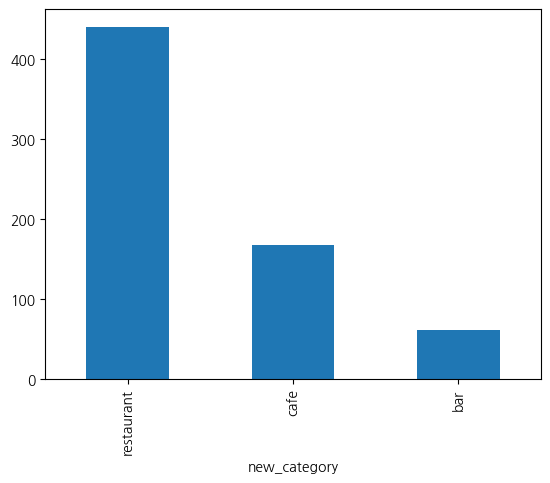

In [26]:
### 필요없는 변수 제거
df = df.drop(['id','title','score_val','descript'], axis=1)

### 결측치 처리
df = df.dropna()

### category 변수 재범주화 → 카페, 음식점, 주점
cafe = ['카페,디저트', '홍차전문점', '카페', '베이커리', '빙수', '케이크전문', '베이글', '브런치',  '토스트',
        '아이스크림', '브런치카페', '와플', '차', '호떡', '테이크아웃커피']

bar = ['요리주점', '바(BAR)', '이자카야', '맥주,호프', '전통,민속주점', '술집', '와인']

df['new_category'] = 'restaurant'
df['new_category'] = np.where(df['category'].isin(cafe), 'cafe', df['new_category'])
df['new_category'] = np.where(df['category'].isin(bar), 'bar', df['new_category'])
df['new_category'].value_counts().plot.bar()

[Text(0, 0, '친절해요'),
 Text(1, 0, '고기 질이 좋아요'),
 Text(2, 0, '인테리어가 멋져요'),
 Text(3, 0, '양이 많아요'),
 Text(4, 0, '가성비가 좋아요'),
 Text(5, 0, '재료가 신선해요'),
 Text(6, 0, '특별한 메뉴가 있어요'),
 Text(7, 0, '혼밥하기 좋아요'),
 Text(8, 0, '단체모임 하기 좋아요'),
 Text(9, 0, '매장이 넓어요'),
 Text(10, 0, '뷰가 좋아요'),
 Text(11, 0, '주차하기 편해요'),
 Text(12, 0, '음악이 좋아요'),
 Text(13, 0, '음식이 맛있어요'),
 Text(14, 0, '기본 안주가 좋아요')]

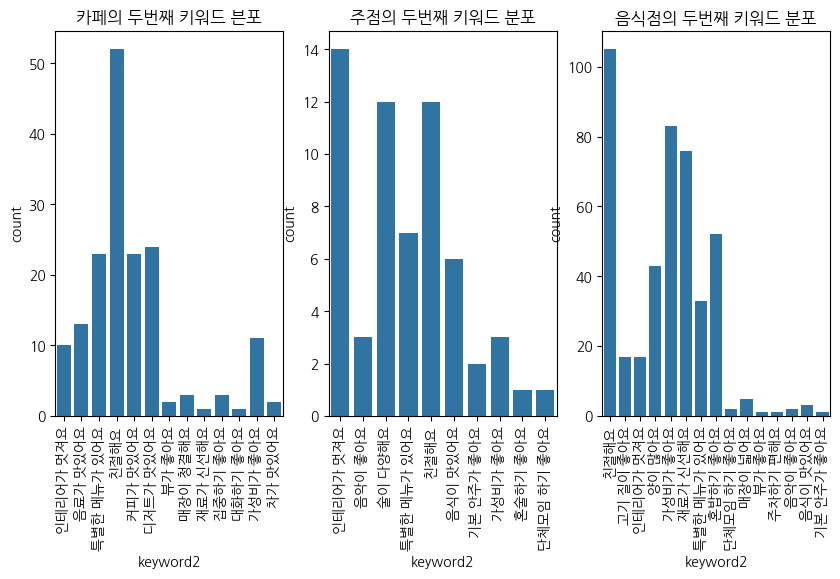

In [27]:
### keyword2 분포 확인
f, ax = plt.subplots(1,3,figsize=(10,5))

sns.countplot(x='keyword2', data=df[df['new_category']=='cafe'], ax=ax[0])
ax[0].set_title('카페의 두번째 키워드 븐포')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.countplot(x='keyword2', data=df[df['new_category']=='bar'], ax=ax[1])
ax[1].set_title('주점의 두번째 키워드 분포')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

sns.countplot(x='keyword2', data=df[df['new_category']=='restaurant'], ax=ax[2])
ax[2].set_title('음식점의 두번째 키워드 분포')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)

In [29]:
### 변수 제거
df = df.drop(['category', 'keyword1', 'keyword3'], axis=1)

### new_category별로 데이터 분할
df_cafe = df[df['new_category']=='cafe']
df_bar = df[df['new_category']=='bar']
df_restaurant = df[df['new_category']=='restaurant']
print(df_cafe.shape, df_bar.shape, df_restaurant.shape)

### 데이터 내보내기
df_cafe.to_csv('./df_cafe.csv', index=False)
df_bar.to_csv('./df_bar.csv', index=False)
df_restaurant.to_csv('./df_restaurant.csv', index=False)

(168, 3) (61, 3) (441, 3)


## df_cafe

In [30]:
### 데이터 불러오기
df_cafe = pd.read_csv('df_cafe.csv', encoding='utf-8')
df_cafe.head(2)

,reviews,keyword2,new_category
0,매장이 넓으면서 소품들이 아기자기하게 잘 꾸며져있고 사진도 잘 나오고 예뻐요~ 단밤...,인테리어가 멋져요,cafe
1,클로리스 코엑스몰점에 작년에 가보고 이번엔 신촌본점을 방문하게 되었어요! 분위기 좋...,음료가 맛있어요,cafe


In [31]:
### 데이터 정제
import re
def clean_review(review):
    # 한글과 공백만 빼고 제거
    review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)

    # 'ㅋㅋㅋ', 'ㅎㅎㅎ', 'ㅠㅠ', 'ㅜㅜ' 같은 단어들 제거
    review = re.sub(r'ㅋ+','',review)
    review = re.sub(r'ㅎ+','',review)
    review = re.sub(r'ㅠ+','',review)
    review = re.sub(r'ㅜ+','',review)

    # 불필요한 공백 제거
    review = review.strip()
    review = re.sub(r'\s+', ' ', review)

    return review

df_cafe['clean_reviews'] = df_cafe['reviews'].apply(clean_review)
df_cafe['clean_reviews'][0]

'매장이 넓으면서 소품들이 아기자기하게 잘 꾸며져있고 사진도 잘 나오고 예뻐요 단밤라떼 달다고 하는 분들도 있는데 전 단것도 밤을 너무 좋아해서 맛있더라구요 커피도 적당히 밸런스도 좋아요 치즈믹스베이글은 빵도 쫀득하고 괜찮았는데 생각보다 치즈 맛이 많이 안나서 아쉬웠어요 신촌에 이런 곳이 층으로 되어 있어 넓고 자리도 많아 대화하러 오거나 작업하기도 좋은 공간이다 인테리어도 컨셉에 맞게 예쁘게 되어있고 음식음료 다 맛있다 특히 애플망고빙수는 아래 씨리얼까지 있어서 더 풍미가 느껴진다 화장실도 깨끗 베이글이 너무 먹고싶어서 찾아보다 방문했는데 이게 머선일이죠 너무 맛있어요 고구마 치즈 베이글 강츄 완전 제스타일 콘베이컨 샌디치도 담백하구 괜춘 하지만 원픽은 고치베 그리고 토마토 스프도 꼭 드세욘 매콤해서 느끼함 싹 잡아줌 쵝오 서울오면 또 올게요오오 잘먹구 갑니당 이름은 베이글하우스지만 제발 수프를 드셔주세요 토마토 수프 그냥 토마토 그 자체인데 매콤해서 너무 감칠맛나고 맛있어요 그리고 크림치즈 진짜 안달고 너무 꾸덕하고 미쳤습니다 진짜 그동안 달아빠진 크림치즈를 먹은 제가 너무 불쌍해요 매장도 넓고 자리도 편하고 쾌적해요 근데 진짜 토마토 수프를 드셔주세요 토마토 수프 괜히 평일쿠폰으로 수프를 주시는게 아니에요 토마토수프 번째 방문이에요 전에 먹구 너무 맛있어서 또왔어요 아직 다 도전해보진 않았지만 블루베리랑 황치즈가 정말 맛있는거같아요 스프도 생각치못했는데 조합도 좋구 꽤 맛있었어요 담엔 토마토스프 도전하러 또올게요 바질 베이글 바질 크림치즈 추천하고 통밀 베이글 토마토숲 진짜 꼭 드세요 너무너무너무너무너무너무 맛있습니다 너무 달고 짠 빵에 점령당한 코리아 너무 맛있어요 그치만 난 자극이 필요하다 하시는 분들 토마토숲 약간 스파이시하다는 것 평일 오전에 방문했어요 토마토 수프 진짜 맛있어요 매콤하고 새콤해서 느끼할 수 있는 부분들을 싹 잡아줘요 굿굿 베이글 맛있어요 공간이 넓어서 여유롭고 층 초록뷰가 이쁘네요 치즈러버로서 고구마 치즈 베이글과 황치즈베이글 그

In [4]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 30.2 MB/s eta 0:00:00


In [35]:
### Konlpy의 Okt로 토큰화
from konlpy.tag import Okt
from tqdm.notebook import tqdm
okt = Okt()  # 선언

# Okt 형태소 분석
reviews = []
for review in tqdm(df_cafe['clean_reviews']):
    tokenized_review = okt.morphs(review, stem=True)  # stem=True로 어간추출까지 진행
    reviews.append(tokenized_review)

df_cafe['tokenized_reviews'] = reviews
print(df_cafe['tokenized_reviews'][0])

  0%|          | 0/168 [00:00<?, ?it/s]

['매장', '이', '넓다', '소품', '들', '이', '아기자기하다', '자다', '꾸미다', '사진', '도', '자다', '나오다', '예쁘다', '단', '밤', '라떼', '달다', '하다', '분', '들', '도', '있다', '전', '단것', '도', '밤', '을', '너무', '좋아하다', '맛있다', '커피', '도', '적당하다', '밸런스', '도', '좋다', '치즈', '믹스', '베이글', '은', '빵', '도', '쫀득', '하고', '괜찮다', '생각', '보다', '치즈', '맛', '이', '많이', '안나', '서', '아쉽다', '신촌', '에', '이렇다', '곳', '이', '층', '으로', '되어다', '있다', '넓다', '자리', '도', '많다', '대화', '하다', '오거', '나', '작업', '하다', '좋다', '공간', '이다', '인테리어', '도', '컨셉', '에', '맞다', '예쁘다', '되어다', '음식', '음료', '다', '맛있다', '특히', '애플', '망고', '빙수', '는', '아래', '씨리얼', '까지', '있다', '더', '풍', '미가', '느껴지다', '화장실', '도', '깨끗', '베이글', '이', '너무', '먹다', '찾아보다', '방문', '하다', '이', '게', '머선', '일이', '죠', '너무', '맛있다', '고구마', '치즈', '베이글', '강츄', '완전', '제', '스타일', '콘', '베이컨', '샌디', '치도', '담백하다', '괜춘', '하지만', '원픽', '은', '고치', '베', '그리고', '토마토', '스프', '도', '꼭', '드세욘', '매콤', '하다', '느끼하다', '싹', '잡다', '줌', '쵝오', '서울', '오다', '또', '오다', '오오', '잘', '먹다', '가다', '이름', '은', '베이글', '하우스', '지만', '제발', '수프', '를', '들다', '토마토', '

In [37]:
### 불용어 제거
with open("./stopword.txt", 'r', encoding='utf-8') as file:
    stop_words = file.readlines()

# 각 불용어 뒤에 있는 '\n' 제거
stop_words = [word.strip() for word in stop_words]
print(stop_words[:10])

# 토큰의 빈도 수 확인
from collections import Counter
all_reviews = [review for sublist in df_cafe['tokenized_reviews'] for review in sublist]
word_freq = Counter(all_reviews)
word_freq_200 = word_freq.most_common(200)

# 결과 확인을 위해 txt 파일로 내보내기
with open('word_freq_200.txt', 'w', encoding='utf-8-sig') as file:
    for item in word_freq_200:
        file.write(f"{item}\n")
print("완료")

# 불용어 추가
add_stop_words = ['도','하다','이','에','가','너무','있다','은','는','이다','오다','보다','을','같다','로','으로','방문','들','다','를','가다','한','진짜','님','의','곳','에서','것','수','정말','않다','하고','들다','요','랑','과','없다','또','되다','넘다','때','안','만','와','싶다','더','고','까지','분','이에요','나','이랑','적','많이','여기','인데','이라','다음','인','제','꼭','처음','자주','엄청','저','분들','하나','라','게','완전','그리고','서','그','정도','나다','잘','좀','주다','에는','특히','되어다','거','엔','두','부터','아주','에도','그렇다','마다','조금','항상','바로','딱','점','그냥','하','지','니']

# 최종 불용어 리스트
stopwords = stop_words + add_stop_words
print(len(stopwords))

# 불용어 제거 함수 정의
def remove_stopwords(review):
    return [word for word in review if word not in stopwords]

# 불용어 제거 적용
filtered_reviews = [remove_stopwords(review) for review in df_cafe['tokenized_reviews']]

# 결과 출력
df_cafe['filtered_reviews'] = filtered_reviews
print(df_cafe['filtered_reviews'][0])

['않다', '되어다', '되다', '하다', '어떻다', '이렇다', '이다', '어제', '매일', '아']
완료
782
['매장', '넓다', '소품', '아기자기하다', '자다', '꾸미다', '사진', '자다', '나오다', '예쁘다', '단', '밤', '라떼', '달다', '전', '단것', '밤', '좋아하다', '맛있다', '커피', '적당하다', '밸런스', '좋다', '치즈', '믹스', '베이글', '빵', '쫀득', '괜찮다', '생각', '치즈', '맛', '안나', '아쉽다', '신촌', '층', '넓다', '자리', '많다', '대화', '오거', '작업', '좋다', '공간', '인테리어', '컨셉', '맞다', '예쁘다', '음식', '음료', '맛있다', '애플', '망고', '빙수', '아래', '씨리얼', '풍', '미가', '느껴지다', '화장실', '깨끗', '베이글', '먹다', '찾아보다', '머선', '일이', '죠', '맛있다', '고구마', '치즈', '베이글', '강츄', '스타일', '콘', '베이컨', '샌디', '치도', '담백하다', '괜춘', '원픽', '고치', '베', '토마토', '스프', '드세욘', '매콤', '느끼하다', '싹', '잡다', '줌', '쵝오', '서울', '오오', '먹다', '이름', '베이글', '하우스', '제발', '수프', '토마토', '수프', '토마토', '자체', '매콤', '감칠맛', '맛있다', '크림', '치즈', '안달', '꾸다', '덕', '미치다', '그동안', '달', '빠지다', '크림', '치즈', '먹다', '불쌍하다', '매장', '넓다', '자리', '편하다', '쾌적하다', '근데', '토마토', '수프', '토마토', '수프', '괜히', '평일', '쿠폰', '수프', '아니다', '토마토', '수프', '번째', '전', '먹다', '맛있다', '아직', '도전', '해보다', '블루베리', '황', '치즈', '맛있다', '스프

In [39]:
### 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=1, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(df_cafe['clean_reviews'])
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
### X/y split
X = tfidf_matrix
y = df_cafe['keyword2']
print(X.shape, y.shape)

### y label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=2024
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
rf = RandomForestClassifier(random_state=2024)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

### test evaluation
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred), columns=col, index=col)
mtx

(168, 44589) (168,)
(117, 44589) (51, 44589) (117,) (51,)
test 정확도 : 0.3725
test f1 score : 0.2377


,디저트가 맛있어요,음료가 맛있어요,차가 맛있어요,특별한 메뉴가 있어요,매장이 청결해요,인테리어가 멋져요,커피가 맛있어요,친절해요,가성비가 좋아요,뷰가 좋아요
디저트가 맛있어요,0,0,0,0,0,0,0,3,0,0
음료가 맛있어요,0,0,0,0,0,0,0,5,0,0
차가 맛있어요,0,1,0,0,0,0,0,0,0,0
특별한 메뉴가 있어요,0,0,0,0,0,0,0,1,0,0
매장이 청결해요,0,0,0,0,0,0,0,4,0,0
인테리어가 멋져요,0,0,0,0,0,0,0,3,0,0
커피가 맛있어요,0,0,0,0,0,0,0,1,0,0
친절해요,0,1,0,0,0,0,0,18,0,0
가성비가 좋아요,0,2,0,0,0,0,0,8,0,0
뷰가 좋아요,0,0,0,0,0,0,0,3,0,1


## df_bar

In [58]:
### 데이터 불러오기
df_bar = pd.read_csv('df_bar.csv', encoding='utf-8')
df_bar.head(2)

,reviews,keyword2,new_category
0,비오는 토요일 맛있게 먹기 좋은 곳입니다. 배가 너무 고파 곱도리탕 먹다가 찍은 사...,인테리어가 멋져요,bar
1,일단 인테리어가 일본 분위기 나서 일본 여행온 느낌나서 너무 좋았구요! 훗카이도 세...,인테리어가 멋져요,bar


In [59]:
### 데이터 정제
import re
def clean_review(review):
    # 한글과 공백만 빼고 제거
    review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)

    # 'ㅋㅋㅋ', 'ㅎㅎㅎ', 'ㅠㅠ', 'ㅜㅜ' 같은 단어들 제거
    review = re.sub(r'ㅋ+','',review)
    review = re.sub(r'ㅎ+','',review)
    review = re.sub(r'ㅠ+','',review)
    review = re.sub(r'ㅜ+','',review)

    # 불필요한 공백 제거
    review = review.strip()
    review = re.sub(r'\s+', ' ', review)

    return review

df_bar['clean_reviews'] = df_bar['reviews'].apply(clean_review)
df_bar['clean_reviews'][0]

'비오는 토요일 맛있게 먹기 좋은 곳입니다 배가 너무 고파 곱도리탕 먹다가 찍은 사진이지만 맛있어서 또오고 싶어요 감태는 감태향이 아쉽지만 맛있을 수 밖에 없는 조합 다양한 술과 맛있는 음식을 함께할 수 있는 곳입니다 곱도리탕을 처음 먹어봤는데 정말 맛있었어요 매콤한 양념이 곱창과 닭고기에 잘 배어 깊은 맛이 났습니다 푸짐한 양에 비해 가격도 합리적이라 만족스러웠어요 친절한 서비스 덕분에 기분 좋게 식사할 수 있었습니다 다음에도 꼭 다시 찾고 싶은 맛집입니다 남자친구랑 비도오고해서 전이 땡겨서 왔어용 막걸리도 종류별로 다있고 일단 치즈감자채전이랑 막걸리 시켰는데 맛있어요 평소에 곱도리탕을 자주 먹는데 술과 함께 먹는 메뉴로 늘 적당하고 맛있습니다 여기도 맛있어서 또 올 것 같아요오 사이드메뉴도 여러가지여서 좋았습니다 친구들이랑 명정도 다같이왔는데 자리도 넓고 너무 좋네요 인테리어도 너무 이쁘고 맛있어요 보기드문 안주맛집 뭘시켜도 맛있네요 전이 진짜 바삭해서 제 최애 주문 메뉴 곱도리탕 치즈 감자채전 인테리어와 컨셉이 독특하고 조명이 어두워서 차로 방문 하기 좋은 곳이었어요 음식은 양도 생각보다 많고 종류가 다양해서 단체로 방문하기 좋은 곳 같습니다 곱도리탕에 재료는 많이 들어가 있으나 곱이 많은 편은 아니었어요 감자채전은 조금 느끼했지만 치즈도 많이 들어가 있고 얇고 바삭해서 맛있었어요 새우도 통통하고 너무 맛있어요 친구들이랑 수다떨기 너무 좋아요 비오는 날 막걸리에 전 먹을 수 있어서 행복했어요 가족끼리 차하러 왔는데 안주가 너무 맛있어서 계속 들어가요 골뱅이 실한것봐 한식술집 찾다가 발견한 부엉이산장 신촌점 대표메뉴인 곱도리탕 너무 맛있게 먹고 왔어요 한식파인데 맛있는 한식안주들이 많아서 자주 방문할 것 같아요 매장컨셉도 너무 예쁘고 아늑하고 좋아여 또 방문할게요'

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 30.2 MB/s eta 0:00:00


In [60]:
### Konlpy의 Okt로 토큰화
from konlpy.tag import Okt
from tqdm.notebook import tqdm
okt = Okt()  # 선언

# Okt 형태소 분석
reviews = []
for review in tqdm(df_bar['clean_reviews']):
    tokenized_review = okt.morphs(review, stem=True)  # stem=True로 어간추출까지 진행
    reviews.append(tokenized_review)

df_bar['tokenized_reviews'] = reviews
print(df_bar['tokenized_reviews'][0])

  0%|          | 0/61 [00:00<?, ?it/s]

['비다', '토요일', '맛있다', '먹기', '좋다', '곳', '이다', '배', '가', '너무', '고프다', '곱', '도리', '탕', '먹다', '찍다', '사진', '이지만', '맛있다', '또', '오다', '싶다', '감태', '는', '감태', '향', '이', '아쉽다', '맛있다', '수', '밖에', '없다', '조합', '다양하다', '술', '과', '맛있다', '음식', '을', '함께', '하다', '수', '있다', '곳', '이다', '곱', '도리', '탕', '을', '처음', '먹다', '보다', '정말', '맛있다', '매콤', '한', '양념', '이', '곱창', '과', '닭고기', '에', '자다', '배다', '깊다', '맛', '이', '나다', '푸다', '짐', '한', '양', '에', '비다', '가격', '도', '합리', '적', '이라', '만족스럽다', '친절하다', '서비스', '덕분', '에', '기분', '좋다', '식사', '하다', '수', '있다', '다음', '에도', '꼭', '다시', '찾다', '싶다', '맛집', '이다', '남자친구', '랑', '비도', '오', '고해', '서', '전이', '땡기다', '오다', '막걸리', '도', '종류', '별로', '다', '있다', '일단', '치즈', '감자', '채다', '막걸리', '시키다', '맛있다', '평소', '에', '곱', '도리', '탕', '을', '자주', '먹다', '술', '과', '함께', '먹다', '메뉴', '로', '늘', '적당하다', '맛있다', '여기', '도', '맛있다', '또', '오다', '것', '같다', '오', '사이드', '메뉴', '도', '여러가지', '여서', '좋다', '친구', '들', '이랑', '명정', '도', '다', '같이', '오다', '자리', '도', '넓다', '너무', '좋다', '인테리어', '도', '너무', '이쁘다', '맛있다', '보기',

In [61]:
### 불용어 제거
with open("./stopword.txt", 'r', encoding='utf-8') as file:
    stop_words = file.readlines()

# 각 불용어 뒤에 있는 '\n' 제거
stop_words = [word.strip() for word in stop_words]
print(stop_words[:10])

# 토큰의 빈도 수 확인
from collections import Counter
all_reviews = [review for sublist in df_bar['tokenized_reviews'] for review in sublist]
word_freq = Counter(all_reviews)
word_freq_200 = word_freq.most_common(200)

# 결과 확인을 위해 txt 파일로 내보내기
with open('word_freq_200.txt', 'w', encoding='utf-8-sig') as file:
    for item in word_freq_200:
        file.write(f"{item}\n")
print("완료")

# 불용어 추가
add_stop_words = ['도','하다','이','에','가','너무','있다','은','는','이다','오다','보다','을','같다','로','으로','방문','들','다','를','가다','한','진짜','님','의','곳','에서','것','수','정말','않다','하고','들다','요','랑','과','없다','또','되다','넘다','때','안','만','와','싶다','더','고','까지','분','이에요','나','이랑','적','많이','여기','인데','이라','다음','인','제','꼭','처음','자주','엄청','저','분들','하나','라','게','완전','그리고','서','그','정도','나다','잘','좀','주다','에는','특히','되어다','거','엔','두','부터','아주','에도','그렇다','마다','조금','항상','바로','딱','점','그냥','하','지','니']

# 최종 불용어 리스트
stopwords = stop_words + add_stop_words
print(len(stopwords))

# 불용어 제거 함수 정의
def remove_stopwords(review):
    return [word for word in review if word not in stopwords]

# 불용어 제거 적용
filtered_reviews = [remove_stopwords(review) for review in df_bar['tokenized_reviews']]

# 결과 출력
df_bar['filtered_reviews'] = filtered_reviews
print(df_bar['filtered_reviews'][0])

['않다', '되어다', '되다', '하다', '어떻다', '이렇다', '이다', '어제', '매일', '아']
완료
782
['비다', '토요일', '맛있다', '먹기', '좋다', '배', '고프다', '곱', '도리', '탕', '먹다', '찍다', '사진', '맛있다', '감태', '감태', '향', '아쉽다', '맛있다', '밖에', '조합', '다양하다', '술', '맛있다', '음식', '곱', '도리', '탕', '먹다', '맛있다', '매콤', '양념', '곱창', '닭고기', '자다', '배다', '깊다', '맛', '푸다', '짐', '양', '비다', '가격', '합리', '만족스럽다', '친절하다', '서비스', '덕분', '기분', '좋다', '식사', '다시', '찾다', '맛집', '남자친구', '비도', '고해', '전이', '땡기다', '막걸리', '종류', '별로', '치즈', '감자', '채다', '막걸리', '맛있다', '평소', '곱', '도리', '탕', '먹다', '술', '먹다', '메뉴', '늘', '적당하다', '맛있다', '맛있다', '사이드', '메뉴', '여러가지', '여서', '좋다', '친구', '명정', '자리', '넓다', '좋다', '인테리어', '이쁘다', '맛있다', '보기', '드물다', '안주', '맛집', '뭘', '맛있다', '전이', '바삭', '최애', '주문', '메뉴', '곱', '도리', '탕', '치즈', '감자', '채다', '인테리어', '컨셉', '독특하다', '조명', '어둡다', '차로', '좋다', '음식', '양도', '생각', '많다', '종류', '다양하다', '단체', '좋다', '곱', '도리', '탕', '재료', '들어가다', '곱', '많다', '편', '아니다', '감자', '채다', '느끼하다', '치즈', '들어가다', '얇다', '바삭', '맛있다', '새우다', '통통하다', '맛있다', '친구', '수다', '떨기', '좋다', '비다', '

In [62]:
### 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=1, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(df_bar['clean_reviews'])
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [68]:
### X/y split
X = tfidf_matrix
y = df_bar['keyword2']
print(X.shape, y.shape)

### y label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=2024
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
rf = RandomForestClassifier(random_state=2024)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

### test evaluation
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred), columns=col, index=col)
mtx

(61, 22638) (61,)
(42, 22638) (19, 22638) (42,) (19,)
test 정확도 : 0.2105
test f1 score : 0.1880


,기본 안주가 좋아요,특별한 메뉴가 있어요,인테리어가 멋져요,술이 다양해요,음식이 맛있어요,친절해요,가성비가 좋아요
기본 안주가 좋아요,0,0,0,0,0,1,0
특별한 메뉴가 있어요,0,0,0,0,0,1,0
인테리어가 멋져요,0,0,1,0,1,2,0
술이 다양해요,0,0,1,0,0,1,0
음식이 맛있어요,0,0,1,0,2,2,0
친절해요,0,0,0,0,2,1,0
가성비가 좋아요,0,0,0,0,0,3,0


## df_restaurant

In [69]:
### 데이터 불러오기
df_restaurant = pd.read_csv('df_restaurant.csv', encoding='utf-8')
df_restaurant.head(2)

,reviews,keyword2,new_category
0,노포식당요즘 인기있는곳이래서 왔어요 주꾸미 삼겹 꽃게새우사리추가해서.먹었는데요 양념...,친절해요,restaurant
1,지나가는데 너무 예뻐서 술집인 줄 알았는데 알고 보니까 신촌 삼겹살 맛집이더라구요 ...,고기 질이 좋아요,restaurant


In [70]:
### 데이터 정제
import re
def clean_review(review):
    # 한글과 공백만 빼고 제거
    review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)

    # 'ㅋㅋㅋ', 'ㅎㅎㅎ', 'ㅠㅠ', 'ㅜㅜ' 같은 단어들 제거
    review = re.sub(r'ㅋ+','',review)
    review = re.sub(r'ㅎ+','',review)
    review = re.sub(r'ㅠ+','',review)
    review = re.sub(r'ㅜ+','',review)

    # 불필요한 공백 제거
    review = review.strip()
    review = re.sub(r'\s+', ' ', review)

    return review

df_restaurant['clean_reviews'] = df_restaurant['reviews'].apply(clean_review)
df_restaurant['clean_reviews'][0]

'노포식당요즘 인기있는곳이래서 왔어요 주꾸미 삼겹 꽃게새우사리추가해서먹었는데요 양념맛이깊이가있어서 볶음밥까지너무맛나네요퐁듀치즈에찍어먹었는데 천상의맛이네요 양도푸짐해서남은것들도 따로포장해서 사장님이챙겨주셨는데요 진짜 맛난거먹이고픈 엄마마음느꼈네용 감사드려요 쭈꾸미가 너무 먹고싶어서 온 신촌 역시 기대를 저버리지 않고 핵존맛 입니다 점심특선으로 먹었는데 가격 착하고 쭈꾸미 좋아하는 우리 여친느님께요 대만족을 하셨습니다 또한 볶음밥 하트로 해주시는데 너무 맛있고 좋아요 술도 싼데 점심이라 패스 진짜 좋아요 다음에 또올께요 집근천데 처음가봄 쭈삼 기본셋팅 홍합 콘치즈 계란까지 알차게 맛있어요 쭈꾸미삼겹 먹었는데 무난무난 맛있어요 볶음밥이 별미입니다 계란찜두 보들거려서 맛있게 먹렀더니 직원분이 리필해쥬셨어요 처음 생겼을때부터 다녔으니까 아마 년은 되었나봐요 이렇게 오랫동안 맛집을 유지하는건 역시나 맛이 있어서 그렇겠지요 가게 인테리어도 옛날 감성으로 정감있고 멋있어요 직원분들도 친절하고 여전히 쭈꾸미 맛있어요 국물이 마법 소스 같은데 국물 너무 얼큰하고 매콤하고 계속 끌리는 마성의 맛 요즘은 물가가 올라서 예전에는 날치알을 주셨는데 지금은 마요네즈를 주신다고 날치알도 맛있었지만 쭈꾸미가 매콤하니 마요네즈 소스를 날치알 대신 얹어 먹어도 매운맛이 중화 되어서 괜찮더라구요 반찬같은 경우는 셀프바가 있어서 직원들 안불러도 편하게 리필해서 먹을 수 있어서 그게 더 좋은것 같아요 계속 갈꺼니까 계속 장사해주세요 이번에도 잘 먹고 갑니다 쭈꾸미가 탱글탱글하고 양도 많고 구성도 알찼어요 적당히 매콤해서 맵찔이도 맛있게 먹을 수 있었습니다 볶음밥에는 치즈랑 계란을 같이 넣고 볶아주시는데 이게 별미네요 사장님께서도 정말 친절하십니다 쭈꾸미도 크고 싱싱하고 양도 많아요 달걀찜도 무한리필이고 야채 셀프바도 있어서 푸짐하고 맛있어요 가게 컨셉이 년대 감성이어서 타임머신타고 과거로 간것 같고 재미있어요 년 이상 신촌맛집으로 생방송에도 방송되었어요 강추합니다 맛 있어요 추가 반찬도 직접 가져다

In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 30.2 MB/s eta 0:00:00


In [71]:
### Konlpy의 Okt로 토큰화
from konlpy.tag import Okt
from tqdm.notebook import tqdm
okt = Okt()  # 선언

# Okt 형태소 분석
reviews = []
for review in tqdm(df_restaurant['clean_reviews']):
    tokenized_review = okt.morphs(review, stem=True)  # stem=True로 어간추출까지 진행
    reviews.append(tokenized_review)

df_restaurant['tokenized_reviews'] = reviews
print(df_restaurant['tokenized_reviews'][0])

  0%|          | 0/441 [00:00<?, ?it/s]

['노포', '식당', '요즘', '인기', '있다', '곳', '이래서', '오다', '주꾸미', '삼겹', '꽃게', '새우', '사리', '추가', '하다', '먹다', '양념', '맛', '이', '깊다', '볶음밥', '까지', '너무', '맛', '나', '네', '요', '퐁듀', '치즈', '에', '찍다', '먹다', '천', '상의', '맛', '이네', '요', '양도', '푸다', '지다', '서남', '은', '것', '들', '도', '따로', '포장', '하다', '사장', '님', '이', '챙기다', '진짜', '맛', '난', '거', '먹이', '고프다', '엄마', '마음', '느끼다', '네', '용', '감사', '드리다', '쭈꾸미', '가', '너무', '먹다', '온', '신촌', '역시', '기대', '를', '저', '버리다', '않다', '핵존맛', '이다', '점심', '특선', '으로', '먹다', '가격', '착하다', '쭈꾸미', '좋아하다', '우리', '여친', '느님', '께', '요', '대', '만족', '을', '하다', '또한', '볶음밥', '하트', '로', '해주다', '너무', '맛있다', '좋다', '술', '도', '싸다', '점심', '이라', '패스', '진짜', '좋다', '다음', '에', '또', '오다', '집', '근', '천', '데', '처음', '가보다', '쭈삼', '기본', '셋팅', '홍합', '콘치', '즈', '계란', '까지', '알차다', '맛있다', '쭈꾸미', '삼겹', '먹다', '무난', '무난', '맛있다', '볶음밥', '이', '별미', '이다', '계란찜', '두', '보', '들다', '려', '서', '맛있다', '먹렀더', '니', '직원', '분', '이', '리', '피다', '쥬셨', '어', '요', '처음', '생기다', '때', '부터', '다니다', '아마', '년', '은', '되어다', '보다', '이렇게', '오랫

In [73]:
### 불용어 제거
with open("./stopword.txt", 'r', encoding='utf-8') as file:
    stop_words = file.readlines()

# 각 불용어 뒤에 있는 '\n' 제거
stop_words = [word.strip() for word in stop_words]
print(stop_words[:10])

# 토큰의 빈도 수 확인
from collections import Counter
all_reviews = [review for sublist in df_restaurant['tokenized_reviews'] for review in sublist]
word_freq = Counter(all_reviews)
word_freq_200 = word_freq.most_common(200)

# 결과 확인을 위해 txt 파일로 내보내기
with open('word_freq_200.txt', 'w', encoding='utf-8-sig') as file:
    for item in word_freq_200:
        file.write(f"{item}\n")
print("완료")

# 불용어 추가
add_stop_words = ['도','하다','이','에','가','너무','있다','은','는','이다','오다','보다','을','같다','로','으로','방문','들','다','를','가다','한','진짜','님','의','곳','에서','것','수','정말','않다','하고','들다','요','랑','과','없다','또','되다','넘다','때','안','만','와','싶다','더','고','까지','분','이에요','나','이랑','적','많이','여기','인데','이라','다음','인','제','꼭','처음','자주','엄청','저','분들','하나','라','게','완전','그리고','서','그','정도','나다','잘','좀','주다','에는','특히','되어다','거','엔','두','부터','아주','에도','그렇다','마다','조금','항상','바로','딱','점','그냥','하','지','니']

# 최종 불용어 리스트
stopwords = stop_words + add_stop_words
print(len(stopwords))

# 불용어 제거 함수 정의
def remove_stopwords(review):
    return [word for word in review if word not in stopwords]

# 불용어 제거 적용
filtered_reviews = [remove_stopwords(review) for review in df_restaurant['tokenized_reviews']]

# 결과 출력
df_restaurant['filtered_reviews'] = filtered_reviews
print(df_restaurant['filtered_reviews'][0])

['않다', '되어다', '되다', '하다', '어떻다', '이렇다', '이다', '어제', '매일', '아']
완료
782
['노포', '식당', '요즘', '인기', '이래서', '주꾸미', '삼겹', '꽃게', '새우', '사리', '추가', '먹다', '양념', '맛', '깊다', '볶음밥', '맛', '퐁듀', '치즈', '찍다', '먹다', '천', '상의', '맛', '이네', '양도', '푸다', '지다', '서남', '따로', '포장', '사장', '챙기다', '맛', '난', '먹이', '고프다', '엄마', '마음', '느끼다', '용', '감사', '드리다', '쭈꾸미', '먹다', '온', '신촌', '역시', '기대', '버리다', '핵존맛', '점심', '특선', '먹다', '가격', '착하다', '쭈꾸미', '좋아하다', '여친', '느님', '께', '대', '만족', '볶음밥', '하트', '해주다', '맛있다', '좋다', '술', '싸다', '점심', '패스', '좋다', '집', '근', '천', '데', '가보다', '쭈삼', '기본', '셋팅', '홍합', '콘치', '즈', '계란', '알차다', '맛있다', '쭈꾸미', '삼겹', '먹다', '무난', '무난', '맛있다', '볶음밥', '별미', '계란찜', '보', '려', '맛있다', '먹렀더', '직원', '리', '피다', '쥬셨', '생기다', '다니다', '아마', '이렇게', '오랫동안', '맛집', '유지', '역시', '맛', '가게', '인테리어', '옛날', '감성', '정감', '멋있다', '직원', '친절하다', '여전하다', '쭈꾸미', '맛있다', '국물', '마법', '소스', '국물', '얼큰하다', '매콤', '계속', '끌리다', '마', '성의', '맛', '요즘', '물가', '올라서다', '예전', '날치', '알', '지금', '마요네즈', '날치', '알도', '맛있다', '쭈꾸미', '매콤', '마요네즈', '소스', '

In [74]:
### 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=1, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(df_restaurant['clean_reviews'])
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
### X/y split
X = tfidf_matrix
y = df_restaurant['keyword2']
print(X.shape, y.shape)

### y label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

### train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=2024
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
rf = RandomForestClassifier(random_state=2024)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

### test evaluation
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred), columns=col, index=col)
mtx

(441, 104834) (441,)
(352, 104834) (89, 104834) (352,) (89,)
test 정확도 : 0.3146
test f1 score : 0.2597


,혼밥하기 좋아요,고기 질이 좋아요,특별한 메뉴가 있어요,인테리어가 멋져요,양이 많아요,친절해요,매장이 넓어요,재료가 신선해요,뷰가 좋아요,가성비가 좋아요
혼밥하기 좋아요,8,0,0,0,0,0,0,9,0,0
고기 질이 좋아요,0,0,0,0,0,0,0,2,0,0
특별한 메뉴가 있어요,0,0,0,0,0,0,0,1,0,0
인테리어가 멋져요,0,0,0,0,0,0,0,1,0,0
양이 많아요,1,0,0,0,0,0,0,7,0,0
친절해요,0,0,0,0,0,0,0,4,0,0
매장이 넓어요,5,0,0,0,0,0,5,12,0,0
재료가 신선해요,4,0,0,0,0,0,1,14,0,0
뷰가 좋아요,1,0,0,0,0,0,0,4,0,0
가성비가 좋아요,4,0,0,0,0,0,1,4,0,1
